<a href="https://colab.research.google.com/github/er-mukeshmahato/Adafruit_SSD1306/blob/master/Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Upload kaggle.json (your Kaggle API token)


In [15]:
from google.colab import files
files.upload()  # Upload kaggle.json file here when prompted

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mukeshmahato1122","key":"79e16915a31ef978d4ff90118f80a710"}'}

# Step 2: Setup Kaggle credentials and install kaggle CLI

In [16]:
import os
import shutil

# Setup kaggle credentials
os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 600)

# Step 3: Download dataset from Kaggle

In [17]:

!kaggle datasets download -d pranavgautam29/chest-x-ray-imagesmultiple-diseases



Dataset URL: https://www.kaggle.com/datasets/pranavgautam29/chest-x-ray-imagesmultiple-diseases
License(s): apache-2.0
chest-x-ray-imagesmultiple-diseases.zip: Skipping, found more recently modified local copy (use --force to force download)


# Step 4: Verify and unzip the dataset

In [18]:

!unzip -o -q /content/chest-x-ray-imagesmultiple-diseases.zip -d /content/data


# Step 5: Import libraries and set parameters

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

data_dir = "/content/data/data"  # your dataset folder
batch_size = 32
img_height = 224
img_width = 224
epochs_initial = 10
epochs_finetune = 40


# Step 6: Load dataset with training and validation splits

In [20]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes found:", class_names)

Found 4452 files belonging to 5 classes.
Using 3562 files for training.
Found 4452 files belonging to 5 classes.
Using 890 files for validation.
Classes found: ['Covid', 'Normal', 'Pneumonia', 'Pneumothorax', 'Tuberculosis']


# --------- Compute class weights ---------

In [21]:

# Extract labels from training dataset
train_labels = np.concatenate([y.numpy() for x, y in train_ds], axis=0)
class_counts = Counter(train_labels)
total = sum(class_counts.values())
class_weight = {cls: total / (num_classes * count) for cls, count in class_counts.items()}
print("Class weights:", class_weight)


Class weights: {np.int32(3): 0.880593325092707, np.int32(1): 0.7915555555555556, np.int32(4): 1.3047619047619048, np.int32(0): 2.3055016181229773, np.int32(2): 0.7138276553106212}


In [22]:
# Step 7: Define data augmentation and prepare datasets

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),            # wider rotation range
    layers.RandomZoom(0.3),                # zoom in/out
    layers.RandomContrast(0.2),            # contrast change
    layers.RandomTranslation(0.2, 0.2),    # shift images horizontally and vertically
    layers.RandomBrightness(0.2),          # brightness jitter
    layers.GaussianNoise(0.05)             # small noise injection
])

# --------- Prepare datasets for performance ---------
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Step 8: Build model using densenet with transfer learning

In [24]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# --------- Build model ---------
inputs = layers.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.densenet.preprocess_input(x)
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=x)

base_model.trainable = False  # freeze base model initially

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax',
                       kernel_regularizer=regularizers.l2(1e-4))(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Step 9: Define callbacks


In [25]:
checkpoint_path = "best_model.keras"
cb = [
    callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', verbose=1),
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
]

# Step 10: Initial training



In [26]:
history_initial = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_initial,
    callbacks=cb,
    class_weight=class_weight
)

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.2800 - loss: 2.0022
Epoch 1: val_loss improved from inf to 0.95830, saving model to best_model.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 63s 259ms/step - accuracy: 0.2808 - loss: 1.9996 - val_accuracy: 0.6090 - val_loss: 0.9583 - learning_rate: 0.0010
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5458 - loss: 1.1790
Epoch 2: val_loss improved from 0.95830 to 0.78293, saving model to best_model.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 206ms/step - accuracy: 0.5460 - loss: 1.1784 - val_accuracy: 0.6742 - val_loss: 0.7829 - learning_rate: 0.0010
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5919 - loss: 1.0311
Epoch 3: val_loss improved from 0.78293 to 0.69327, saving model to best_model.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 39s 192ms/step - accuracy: 0.5920 - loss: 1.0306 - val_accuracy: 0.7191 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step

# Step 11: Fine-tuning

In [27]:
 # Unfreeze last 60 layers
for layer in base_model.layers[-60:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_finetune,
    callbacks=cb,
    class_weight=class_weight
)

Epoch 1/40
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.2650 - loss: 2.3135
Epoch 1: val_loss did not improve from 0.58764
112/112 ━━━━━━━━━━━━━━━━━━━━ 50s 253ms/step - accuracy: 0.2652 - loss: 2.3121 - val_accuracy: 0.6596 - val_loss: 0.7912 - learning_rate: 1.0000e-05
Epoch 2/40
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.3797 - loss: 1.6582
Epoch 2: val_loss did not improve from 0.58764
112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 205ms/step - accuracy: 0.3799 - loss: 1.6573 - val_accuracy: 0.6090 - val_loss: 0.9067 - learning_rate: 1.0000e-05
Epoch 3/40
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.4609 - loss: 1.3460
Epoch 3: val_loss did not improve from 0.58764
112/112 ━━━━━━━━━━━━━━━━━━━━ 41s 201ms/step - accuracy: 0.4612 - loss: 1.3451 - val_accuracy: 0.6551 - val_loss: 0.8193 - learning_rate: 1.0000e-05
Epoch 4/40
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5607 - loss: 1.0490
Epoch 4: val_loss did not improve from 0.58764
112/112 ━━━━━━━━

# Step 12: Save final model


In [28]:
model.save("final_finetuned_model.keras")
print("Fine-tuned model saved.")

Fine-tuned model saved.


# Step 13: Plot training results

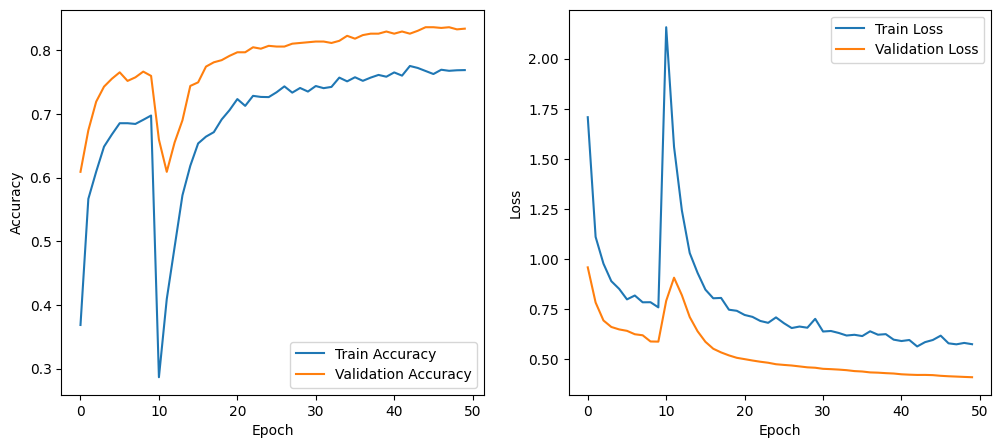

In [29]:
acc = history_initial.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history_initial.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history_initial.history['loss'] + history_finetune.history['loss']
val_loss = history_initial.history['val_loss'] + history_finetune.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()